In [1]:
#import library

import os
import rasterio, json
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask as rasterio_mask  # Alias the mask function
from rasterio.enums import Resampling
from shapely.geometry import mapping
from rasterio.enums import Resampling
import pandas as pd
from rasterio.windows import from_bounds
from tqdm import tqdm
from rasterio.shutil import copy as rio_copy
import tempfile

# Data

In [2]:
sentinel_2019_data = 'data/07_final-sentinel-data/2019'
sentinel_2024_data = 'data/07_final-sentinel-data/2024'
dem = 'data/08-DEM-data/DEM-DAegu-merged-clipmask.tif'

In [5]:
#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)


#### 2019

In [3]:
def find_first(dataset_dir, pattern):
  files = glob.glob(os.path.join(dataset_dir, pattern))
  return files[0] if files else None

def load_bands(dataset_dir):
  return{
      'B02': find_first(dataset_dir, '*B02*.tif'),
      'B03': find_first(dataset_dir, '*B03*.tif'),
      'B04': find_first(dataset_dir, '*B04*.tif'),
      'B08': find_first(dataset_dir, '*B08*.tif'),
      'B11': find_first(dataset_dir, '*B11*.tif')
  }

def show_raster_info(band_paths):
  with rasterio.open(band_paths) as ref:
    print("=== Raster Info ===")
    print("File:", band_paths)
    print("Original resolution (height, width):", (ref.height, ref.width))
    print("CRS:", ref.crs)
    print("Bounds:", ref.bounds)
    print("Number of Bands:", ref.count)
    print("Data Type:", ref.dtypes)
    print("Transform (affine):", ref.transform)
    print("====================\n")


data_bands_2019= load_bands(sentinel_2019_data)
data_bands_2024= load_bands(sentinel_2024_data)

show_raster_info(data_bands_2019['B08'])
show_raster_info(data_bands_2024['B08'])

=== Raster Info ===
File: data/07_final-sentinel-data/2019\T52SDE_20190604T020659_B08_10m_clipped.tif
Original resolution (height, width): (4531, 3714)
CRS: EPSG:32652
Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|

=== Raster Info ===
File: data/07_final-sentinel-data/2024\T52SDE_20240612T020701_B08_10m_clipped.tif
Original resolution (height, width): (4531, 3714)
CRS: EPSG:32652
Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
Number of Bands: 1
Data Type: ('uint16',)
Transform (affine): | 10.00, 0.00, 441320.00|
| 0.00,-10.00, 3985790.00|
| 0.00, 0.00, 1.00|



Text(0, 0.5, 'Y (preview pixel)')

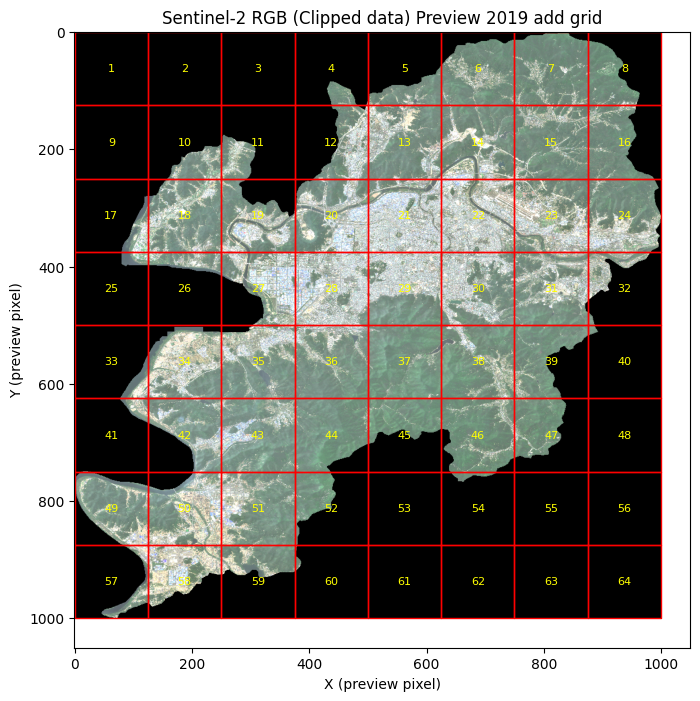

In [7]:
#Load satellite band data as arrays
grid_n = 8 #
scale = 1000 #means: resample to 1000x1000

with rasterio.open(data_bands_2019["B04"]) as r: R2019_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2019["B03"]) as r: G2019_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2019["B02"]) as r: B2019_f = r.read(1, out_shape=(scale, scale))

#qstretch (builded function before)
#Merge into RGB image
rgb = np.dstack([qstretch(R2019_f), qstretch(G2019_f), qstretch(B2019_f)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

# grid marker
h, w = rgb.shape[:2]
step_x = w // grid_n
step_y = h // grid_n

index = 1
for i in range(grid_n):
    for j in range(grid_n):
        x0, x1 = j*step_x, (j+1)*step_x
        y0, y1 = i*step_y, (i+1)*step_y
        ax.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],'r-',lw=1)
        ax.text(x0+step_x/2, y0+step_y/2, str(index),
                color='yellow', ha='center', va='center', fontsize=8)
        index += 1

plt.title("Sentinel-2 RGB (Clipped data) Preview 2019 add grid")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")


Saving done: ['data/04-output/2019/grids\\T52SDE_20190604T020659_B02_10m_clipped_grid34.tif', 'data/04-output/2019/grids\\T52SDE_20190604T020659_B03_10m_clipped_grid34.tif', 'data/04-output/2019/grids\\T52SDE_20190604T020659_B04_10m_clipped_grid34.tif', 'data/04-output/2019/grids\\T52SDE_20190604T020659_B08_10m_clipped_grid34.tif', 'data/04-output/2019/grids\\B11_resampled_10m_2019_grid34.tif']


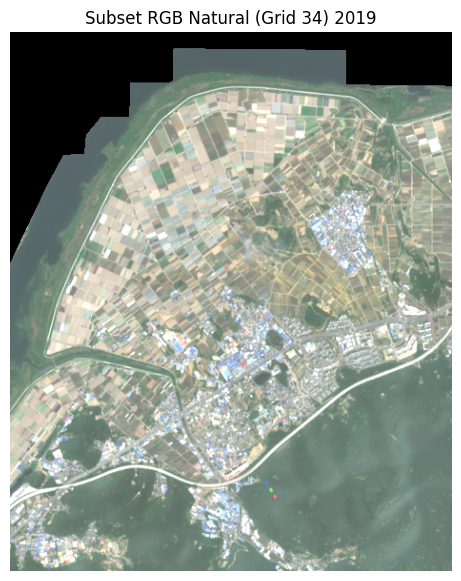

In [10]:
Save_dir_2019 = "data/04-output/2019/grids"
os.makedirs(Save_dir_2019, exist_ok=True)

ref = rasterio.open(data_bands_2019["B08"])
bounds = ref.bounds

#extract specific tiles
def crop_by_index(idx, grid_n=5):
    row = (idx-1)//grid_n #
    col = (idx-1)%grid_n

    x0 = bounds.left   + (bounds.right-bounds.left) * (col   /grid_n)
    x1 = bounds.left   + (bounds.right-bounds.left) * ((col+1)/grid_n)
    y0 = bounds.top    - (bounds.top-bounds.bottom) * ((row+1)/grid_n)
    y1 = bounds.top    - (bounds.top-bounds.bottom) * (row   /grid_n)
    bbox = (x0, y0, x1, y1)

    #crop each band
    outputs = []
    subset_bands = {}
    for k, v in data_bands_2019.items():
        if v is None:
            continue
        with rasterio.open(v) as src:
            win = from_bounds(*bbox, src.transform)
            arr = src.read(1, window=win)
            transform = src.window_transform(win)
            meta = src.meta.copy()
            meta.update({"height": arr.shape[0], "width": arr.shape[1], "transform": transform})
            out_path = os.path.join(Save_dir_2019, os.path.basename(v).replace(".tif", f"_grid{idx}.tif"))
            with rasterio.open(out_path, "w", **meta) as dst:
                dst.write(arr, 1)
            outputs.append(out_path)
            subset_bands[k] = arr

    print("Saving done:", outputs)

    # true colour
    if all(b in subset_bands for b in ["B04","B03","B02"]):
        disp = np.dstack([
            qstretch(subset_bands["B04"]),
            qstretch(subset_bands["B03"]),
            qstretch(subset_bands["B02"])
        ])
        plt.figure(figsize=(7,7))
        plt.imshow(disp, origin="upper")
        plt.title(f"Subset RGB Natural (Grid {idx}) 2019")
        plt.axis("off")
        plt.savefig("data/04-output/2019/selected_grid",
            dpi=300, bbox_inches='tight')
        plt.show()

    return outputs, subset_bands, bbox

idx = 34
outputs, subset_bands, bbox = crop_by_index(idx, grid_n)

### 2024

Text(0, 0.5, 'Y (preview pixel)')

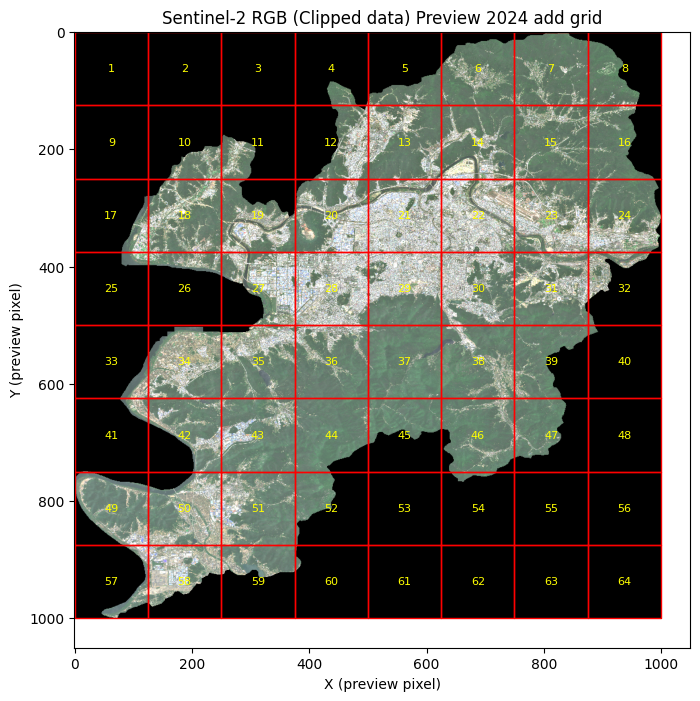

In [11]:
#Load satellite band data as arrays
grid_n = 8 #
scale = 1000 #means: resample to 1000x1000

with rasterio.open(data_bands_2024["B04"]) as r: R2024_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2024["B03"]) as r: G2024_f = r.read(1, out_shape=(scale, scale))
with rasterio.open(data_bands_2024["B02"]) as r: B2024_f = r.read(1, out_shape=(scale, scale))

#qstretch (builded function before)
#Merge into RGB image
rgb = np.dstack([qstretch(R2024_f), qstretch(G2024_f), qstretch(B2024_f)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

# grid marker
h, w = rgb.shape[:2]
step_x = w // grid_n
step_y = h // grid_n

index = 1
for i in range(grid_n):
    for j in range(grid_n):
        x0, x1 = j*step_x, (j+1)*step_x
        y0, y1 = i*step_y, (i+1)*step_y
        ax.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],'r-',lw=1)
        ax.text(x0+step_x/2, y0+step_y/2, str(index),
                color='yellow', ha='center', va='center', fontsize=8)
        index += 1

plt.title("Sentinel-2 RGB (Clipped data) Preview 2024 add grid")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")


Saving done: ['data/04-output/2024/grids\\T52SDE_20240612T020701_B02_10m_clipped_grid34.tif', 'data/04-output/2024/grids\\T52SDE_20240612T020701_B03_10m_clipped_grid34.tif', 'data/04-output/2024/grids\\T52SDE_20240612T020701_B04_10m_clipped_grid34.tif', 'data/04-output/2024/grids\\T52SDE_20240612T020701_B08_10m_clipped_grid34.tif', 'data/04-output/2024/grids\\B11_resampled_10m_2024_grid34.tif']


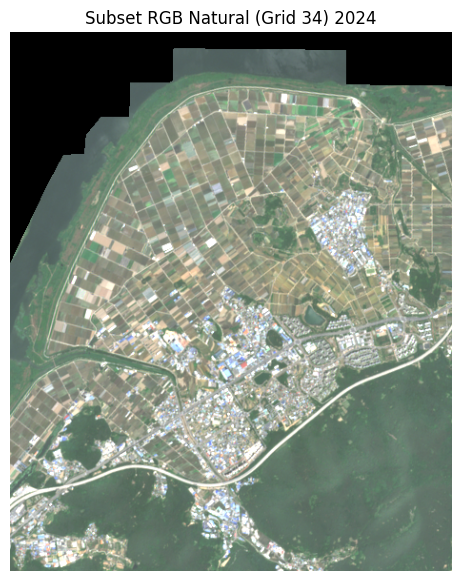

In [ ]:
Save_dir_2024 = "data/04-output/2024/grids"
os.makedirs(Save_dir_2024, exist_ok=True)

ref = rasterio.open(data_bands_2024["B08"])
bounds = ref.bounds

#extract specific tiles
def crop_by_index(idx, grid_n=5):
    row = (idx-1)//grid_n #
    col = (idx-1)%grid_n

    x0 = bounds.left   + (bounds.right-bounds.left) * (col   /grid_n)
    x1 = bounds.left   + (bounds.right-bounds.left) * ((col+1)/grid_n)
    y0 = bounds.top    - (bounds.top-bounds.bottom) * ((row+1)/grid_n)
    y1 = bounds.top    - (bounds.top-bounds.bottom) * (row   /grid_n)
    bbox = (x0, y0, x1, y1)

    #crop each band
    outputs = []
    subset_bands = {}
    for k, v in data_bands_2024.items():
        if v is None:
            continue
        with rasterio.open(v) as src:
            win = from_bounds(*bbox, src.transform)
            arr = src.read(1, window=win)
            transform = src.window_transform(win)
            meta = src.meta.copy()
            meta.update({"height": arr.shape[0], "width": arr.shape[1], "transform": transform})
            out_path = os.path.join(Save_dir_2024, os.path.basename(v).replace(".tif", f"_grid{idx}.tif"))
            with rasterio.open(out_path, "w", **meta) as dst:
                dst.write(arr, 1)
            outputs.append(out_path)
            subset_bands[k] = arr

    print("Saving done:", outputs)

    # true colour
    if all(b in subset_bands for b in ["B04","B03","B02"]):
        disp = np.dstack([
            qstretch(subset_bands["B04"]),
            qstretch(subset_bands["B03"]),
            qstretch(subset_bands["B02"])
        ])
        plt.figure(figsize=(7,7))
        plt.imshow(disp, origin="upper")
        plt.title(f"Subset RGB Natural (Grid {idx}) 2024")
        plt.axis("off")
        plt.savefig("data/04-output/2024/selected_grid",
            dpi=300, bbox_inches='tight')
        plt.show()

    return outputs, subset_bands, bbox

idx = 34
outputs, subset_bands, bbox = crop_by_index(idx, grid_n)

## Compute NDVI, NDBI and MNDWI

## NDVI

In [13]:
# NDVI function
def compute_ndvi(dataset_dir, output_path=None):
    bands = load_bands(dataset_dir)
    red_path = bands['B04']
    nir_path = bands['B08']

    with rasterio.open(red_path) as red_src, rasterio.open(nir_path) as nir_src:
        red = red_src.read(1).astype('float32')
        nir = nir_src.read(1).astype('float32')

        # NDVI formula
        ndvi = (nir - red) / (nir + red + 1e-10)

        if output_path:
            meta = red_src.meta
            meta.update(driver='GTiff', dtype=rasterio.float32)
            with rasterio.open(output_path, 'w', **meta) as dst:
                dst.write(ndvi, 1)

    return ndvi